# DKTC EDA

## 1. 데이터 불러오기 및 기본 정보 확인

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# 한글 폰트 설정
plt.rc('font', family='AppleGothic')

print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Seaborn version:', sns.__version__)

Pandas version: 2.3.1
Numpy version: 1.26.4
Seaborn version: 0.13.2


In [2]:
train_df = pd.read_csv('../../data/train.csv')
test_df = pd.read_csv('../../data/test.csv')

asdf = pd.read_csv('../../data/train_daily.csv')

train_df = pd.concat([train_df, asdf], ignore_index=True)

### 학습 데이터 확인

In [3]:
train_df.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4850 entries, 0 to 4849
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           4850 non-null   int64 
 1   class         4850 non-null   object
 2   conversation  4850 non-null   object
dtypes: int64(1), object(2)
memory usage: 113.8+ KB


### 테스트 데이터 확인

In [5]:
test_df.head()

,idx,text
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   idx     500 non-null    object
 1   text    500 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB


## 2. 클래스 분포 확인

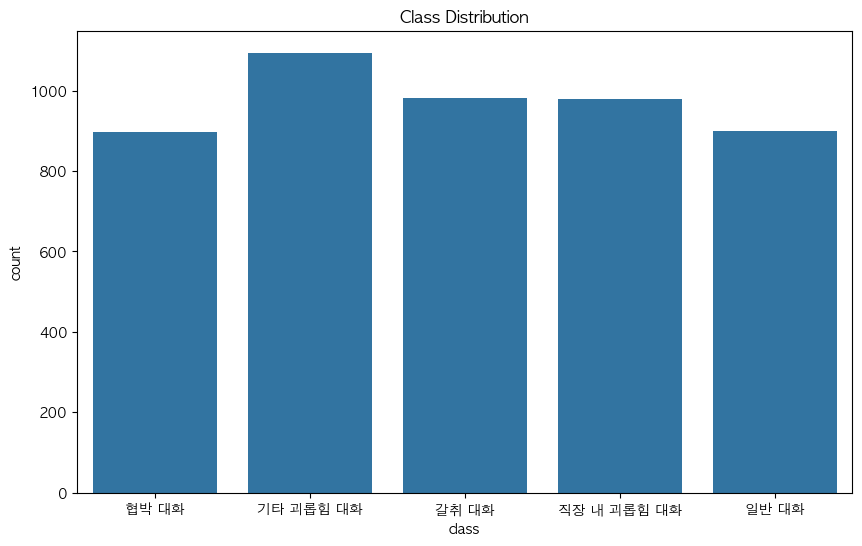

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='class')
plt.title('Class Distribution')
plt.show()

## 3. 대화 길이 분석

In [8]:
train_df["conversation_len"] = train_df["conversation"].apply(len)
test_df["conversation_len"] = test_df["text"].apply(len)

train_df['conversation_len'].describe()

count    4850.000000
mean      205.259175
std       105.252891
min        41.000000
25%       137.000000
50%       182.000000
75%       252.000000
max       874.000000
Name: conversation_len, dtype: float64

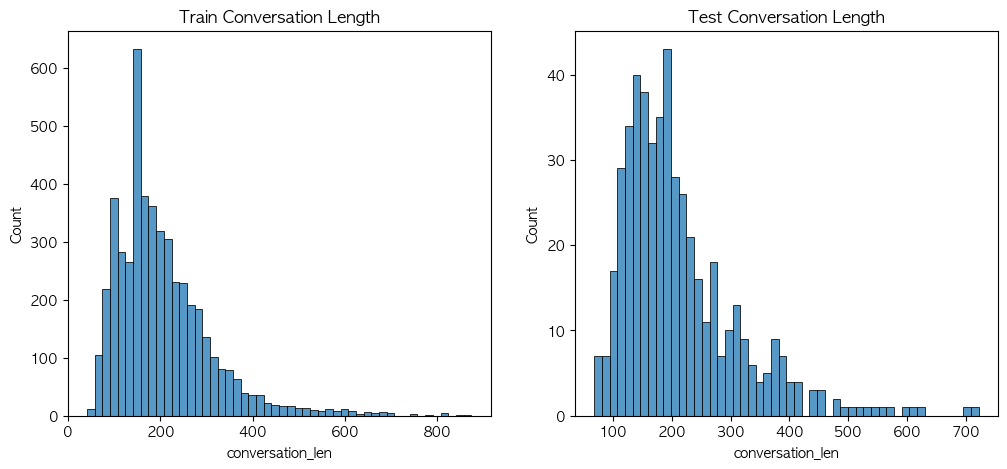

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=train_df, x='conversation_len', bins=50)
plt.title('Train Conversation Length')

plt.subplot(1, 2, 2)
sns.histplot(data=test_df, x='conversation_len', bins=50)
plt.title('Test Conversation Length')

plt.show()

## 4. 클래스별 대화 길이 분석

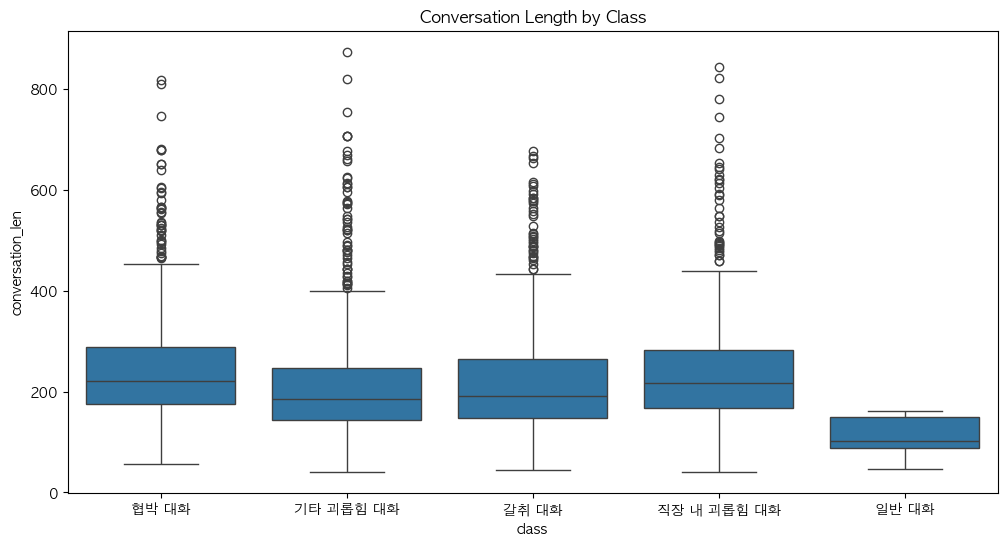

In [10]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='class', y='conversation_len')
plt.title('Conversation Length by Class')
plt.show()

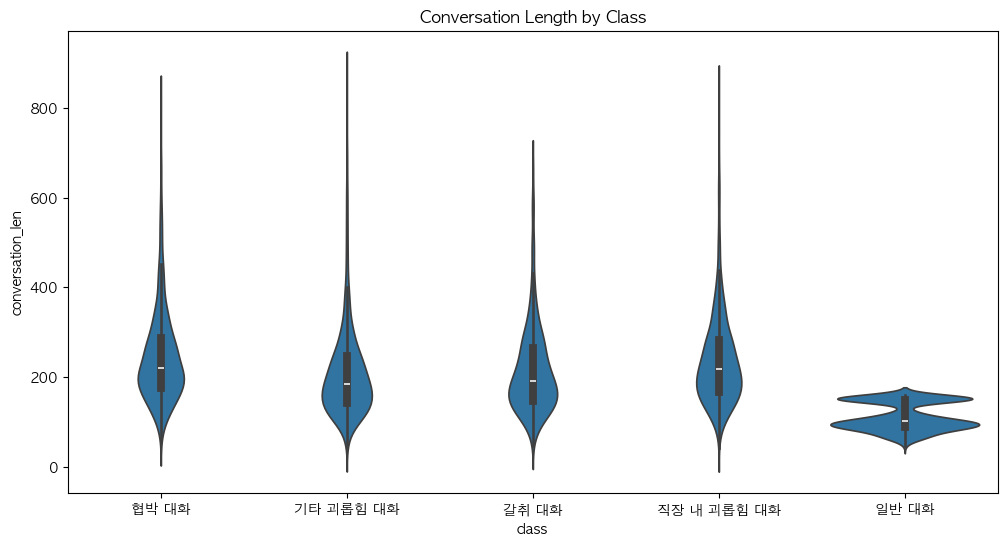

In [11]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=train_df, x='class', y='conversation_len')
plt.title('Conversation Length by Class')
plt.show()

## 5. 감정 분석

In [12]:
# from transformers import pipeline
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 사전 학습된 감성 분석 모델 로드
# sentiment_analyzer = pipeline('sentiment-analysis', model='monologg/koelectra-base-v3-discriminator')

# # 감성 분석 함수 정의
# def get_sentiment(text):
#     # 모델이 처리할 수 있는 최대 길이에 맞춰 텍스트를 자릅니다.
#     result = sentiment_analyzer(text[:512])
#     return result[0]['label']

# # 학습 데이터에 감성 분석 적용
# train_df['sentiment'] = train_df['conversation'].apply(get_sentiment)

# # 클래스별 감성 분포 시각화
# plt.figure(figsize=(10, 6))
# sns.countplot(data=train_df, x='class', hue='sentiment')
# plt.title('Sentiment Distribution by Class')
# plt.show()

# # 감성 분석 결과 확인
# print(train_df[['class', 'sentiment']].value_counts())

## 6. N-gram 분석

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# 클래스별 가장 흔한 2-gram(bi-gram)을 찾는 함수
def get_top_n_bigram(corpus, n=None, r=2):
    vec = CountVectorizer(ngram_range=(r, r), max_features=2000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# 각 클래스별로 상위 10개의 bi-gram 출력
print("--- Top 10 bigrams ---")
for class_name in train_df['class'].unique():
    print(f"--- {class_name} Top 10 Bigrams ---")
    text_corpus = train_df[train_df['class'] == class_name]['conversation']
    top_bigrams = get_top_n_bigram(text_corpus, n=10)
    print(top_bigrams)
    
# 각 클래스별로 상위 10개의 tri-gram 출력
print("--- Top 10 trigrams ---")
for class_name in train_df['class'].unique():
    print(f"--- {class_name} Top 10 Trigrams ---")
    text_corpus = train_df[train_df['class'] == class_name]['conversation']
    top_trigrams = get_top_n_bigram(text_corpus, n=10, r=3)
    print(top_trigrams)

--- Top 10 bigrams ---
--- 협박 대화 Top 10 Bigrams ---
[('지금 당장', 34), ('내가 지금', 28), ('제발 살려주세요', 26), ('그게 무슨', 24), ('시키는 대로', 21), ('시간을 주세요', 21), ('제발 살려줘', 20), ('수가 있어', 20), ('그래 그럼', 19), ('정말 죄송합니다', 19)]
--- 기타 괴롭힘 대화 Top 10 Bigrams ---
[('말이 너무', 26), ('죄송합니다 고객님', 24), ('무슨 소리야', 21), ('그게 무슨', 19), ('제발 그만해', 19), ('말을 그렇게', 18), ('그래 내가', 15), ('무슨 말을', 15), ('죄송합니다 손님', 15), ('아니 내가', 14)]
--- 갈취 대화 Top 10 Bigrams ---
[('뒤져서 나오면', 51), ('돈이 없어', 40), ('저요 그래', 36), ('돈이 없어서', 33), ('안돼 이거', 30), ('없어서 그래', 29), ('맞고 줄래', 28), ('어이 거기', 27), ('진짜 없어', 26), ('지금 당장', 24)]
--- 직장 내 괴롭힘 대화 Top 10 Bigrams ---
[('정말 죄송합니다', 40), ('죄송합니다 제가', 34), ('아닌 같습니다', 32), ('그게 아니라', 29), ('아닙니다 죄송합니다', 25), ('열심히 하겠습니다', 25), ('이건 아닌', 23), ('죄송합니다 죄송하면', 22), ('죄송합니다 부장님', 22), ('죄송합니다 다시', 21)]
--- 일반 대화 Top 10 Bigrams ---
[('같이 가자', 322), ('재밌을 거야', 313), ('분위기도 좋고', 302), ('많이 찍었어', 302), ('같이 하면', 301), ('보여줘 나도', 301), ('우리 같이', 301), ('진짜 인상', 300), ('인상 깊었어', 300), ('깊었어 분위기도', 

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from mecab_ko import Tagger

# MeCab Tagger 인스턴스 생성
mecab_tagger = Tagger()

# 명사 추출을 위한 함수 정의
def extract_nouns(text):
    nouns = []
    parsed = mecab_tagger.parse(text)
    lines = parsed.split('\n')  # 줄바꿈 문자로 분리
    for line in lines:
        if '\t' in line:  # 탭 문자가 포함된 라인만 처리
            parts = line.split('\t')
            word = parts[0]
            tag_info = parts[1]
            pos = tag_info.split(',')[0]
            if pos.startswith('N'):  # 품사가 명사(N)인 경우
                nouns.append(word)
    return nouns

# 각 대화에서 명사를 추출하여 공백으로 연결된 문자열 리스트 생성
noun_list = train_df['conversation'].apply(lambda x: ' '.join(extract_nouns(x)))

# 명사 추출이 잘 되었는지 샘플 확인
print("--- 명사 추출 샘플 ---")
print(f"{noun_list.head().tolist()}\n")


# Document-Term Matrix 생성 (min_df 값을 조금 낮춰 덜 엄격하게 설정)
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words=['입니다', '있습니다', '그냥',
'정말', '진짜'])
dtm = vectorizer.fit_transform(noun_list)

# LDA 모델 학습 (5개의 토픽)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# 토픽별 주요 단어 출력 함수
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

# 결과 출력
print("--- LDA Topic Modeling 결과 (상위 10개 단어) ---")
feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, feature_names, 10)

--- 명사 추출 샘플 ---
['너 스스로 애원 것 거 우리 사건 너 선택 너 가족 너 선택 선택 너 가족 거 선택 번 이', '길동 경찰서 시 분 마트 폭발물 설치 거 번 얘기 장난 전화 시 분 마트 폭발물 거 장난 전화 업무 방해죄 해당 판단 너 길동 경찰서 폭발물 선생 난 이야기 경고 말', '너 거 나 남자 니 거 지영 너 키 재 도 거 너 군대 니 나 데 거 난쟁이 너 희망 이상 키 수술 니 엄마 그거 나람 키', '거기 너 말 너 일 너 옷 돈 돈 넌 피시방 콜 콜 마지막 기회 거', '날 저희 회사 선크림 번 손등 선크림 필요 중 번 여기 번 성분 성분 거 피부 피부 이번 연구 건데 피부 신가 돈 것 돈 이거 누구 당신 거 권유 강매 거 갈취 거 내 말 적 그것 걸 누구 하나 당신 거 당신 이 사람 갈취 화딱지 나']

--- LDA Topic Modeling 결과 (상위 10개 단어) ---
Topic #0: 여기 사람 우리 어디 시간 생각 고객 이거 환불 아빠
Topic #1: 친구 자네 우리 남자 이거 그게 미안 하나 사장 이번
Topic #2: 회사 대리 사람 이거 부장 생각 엄마 말씀 과장 업무
Topic #3: 기분 사진 다음 이번 우리 분위기 인상 일정 전환 지네
Topic #4: 우리 미안 신고 어디 이거 사람 가족 새끼 소리 시간



--- 클래스별 평균 토픽 분포 ---


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
class,,,,,
갈취 대화,0.240443,0.262879,0.119419,0.053473,0.323786
기타 괴롭힘 대화,0.267710,0.249727,0.152984,0.078558,0.251021
일반 대화,0.175557,0.094773,0.127803,0.484459,0.117407
직장 내 괴롭힘 대화,0.129028,0.157120,0.605376,0.037748,0.070728
협박 대화,0.224484,0.164223,0.111415,0.038121,0.461757


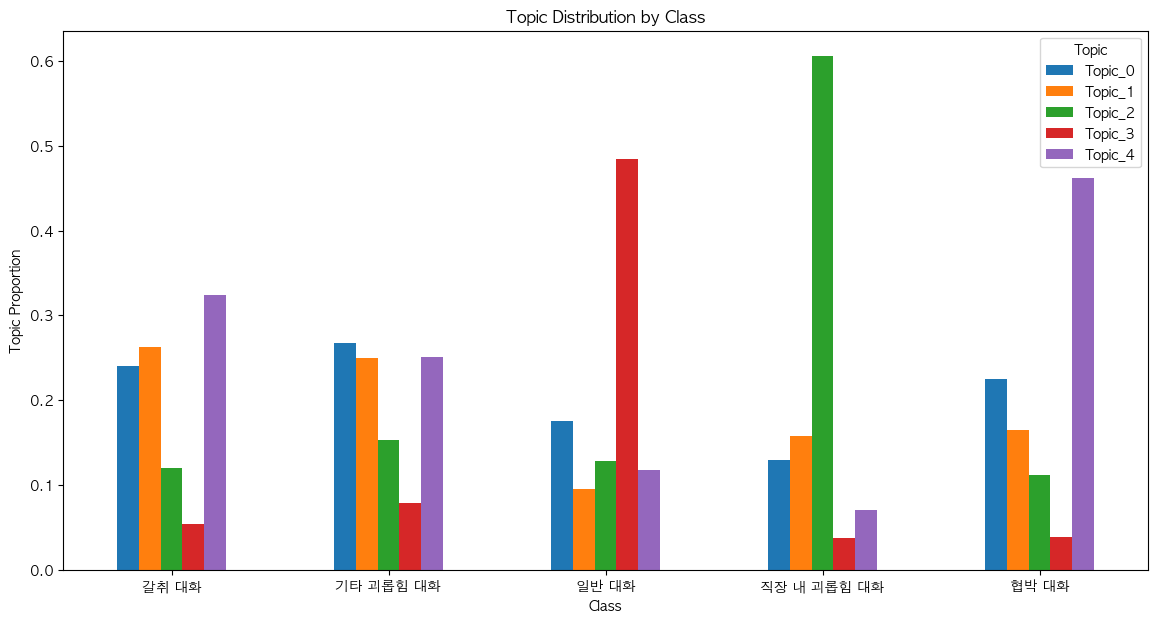

In [15]:
# LDA 모델이 각 대화에 대해 어떤 토픽 분포를 갖는지 확인
topic_distribution = lda.transform(dtm)

# 원래 데이터프레임에 토픽 분포 추가
topic_df = pd.DataFrame(topic_distribution, columns=[f'Topic_{i}' for i in range(5)])
train_with_topics_df = pd.concat([train_df, topic_df], axis=1)

# 클래스별 평균 토픽 분포 계산
class_topic_distribution = train_with_topics_df.groupby('class')[[f'Topic_{i}' for i in range(5)]].mean()

print("--- 클래스별 평균 토픽 분포 ---")
display(class_topic_distribution)

# 시각화
class_topic_distribution.plot(kind='bar', figsize=(14, 7), rot=0)
plt.title('Topic Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Topic Proportion')
plt.legend(title='Topic')
plt.show()

In [16]:
#!pip install faker

In [17]:
import random
import csv
from faker import Faker

fake = Faker("ko_KR")

# 확장된 주제별 질문 + 대응 답변
topics = {
    "날씨": [
        ("오늘 날씨 진짜 좋다.", ["그러게, 산책하기 딱 좋네.", "맞아 덥더라.", "내일은 더 춥대.", "햇볕이 따뜻하네."]),
        ("비 많이 올 것 같지 않아?", ["응, 우산 챙겨야겠다.", "그러네, 아침에도 흐렸어.", "주말엔 맑다더라.", "비 올 때 집에서 쉴까?"]),
        ("어제 비 때문에 힘들었어.", ["나도 젖었어.", "그래서 늦었지?", "다음엔 우산 꼭 챙겨."]),
    ],
    "음식": [
        ("점심 뭐 먹을래?", ["나는 치킨.", "라면 땡겨.", "분식 어때?", "김밥 어때?"]),
        ("치킨 땡긴다.", ["나도 치킨 좋아해.", "어제도 먹었는데 또?", "피자도 괜찮잖아.", "양념치킨 어때?"]),
        ("저녁 메뉴 추천해줘.", ["불고기 어떠신가요?", "짜장면 어때?", "집밥이 최고야."]),
    ],
    "영화": [
        ("주말에 영화 보러 갈래?", ["좋아, 무슨 영화 볼까?", "난 액션 보고 싶어.", "시간 맞으면 보자.", "코미디 어때?"]),
        ("어제 본 영화 진짜 재밌었어.", ["뭐 봤는데?", "나도 보려고 했는데!", "난 별로였어.", "추천해줄까?"]),
        ("최신 영화 뭐가 좋대?", ["SF가 인기야.", "로맨스도 괜찮지.", "리뷰 확인해봐."]),
        (f"{fake.word().capitalize()} 영화 재밌어 보이네.", ["정말? 나도 보고 싶다.", "장르가 뭔데?", "같이 보자!"]),  # 동적 질문 추가
        ("최근에 본 영화 중 추천할 만한 거 있어?", ["{movie} 좋았어.", "액션 영화는 {movie}가 최고.", "코미디로 {movie} 어때?"]),  # {movie}는 faker로 대체 가능
    ],
    "여행": [
        ("여름 휴가 어디 갈 거야?", ["{city} 갈까 생각 중이야.", "아직 못 정했어.", "바다 가고 싶어.", "산으로 가고 싶네."]),
        ("해외여행 가고 싶다.", ["맞아, 일본 가고 싶어.", "유럽도 좋지.", "돈만 있으면 당장 가지.", "동남아 어때?"]),
        ("지난 여행 기억나?", ["재밌었지.", "사진 다시 봐야겠다.", "다음엔 더 가고 싶어."]),
    ],
    "직장": [
        ("오늘 회의 힘들었지?", ["응 진짜 길더라.", "나 졸릴 뻔했어.", "그래도 끝나서 다행.", "내일 더 바빠질듯."]),
        ("프로젝트 언제 끝날까?", ["아마 다음 달쯤?", "생각보다 오래 걸릴 듯.", "주말에 좀 해야겠어.", "팀장한테 물어봐야겠네."]),
        ("업무 너무 많다.", ["나도 그래.", "휴가 내보는 게 어때?", "같이 해결하자."]),
    ]
}

fillers = [
    "헐 진짜?", "와 대박", "오 그렇구나.", "나도 그렇게 생각했어.", 
    "재밌네.", "그건 몰랐네.", "음… 글쎄.", "좋네!", 
    "정말?", "이야, 놀랍다.", "그렇게 들리네."
]

closings = [
    "그럼 내일 보자.", "퇴근하고 연락할게.", "오늘은 여기까지 하자.",
    "조심히 들어가!", "주말에 또 얘기하자.", "잘 가!"
]

def generate_conversation():
    num_turns = random.randint(12, 18)
    conversation = []
    
    for _ in range(num_turns // 2):
        topic = random.choice(list(topics.keys()))
        q, answers = random.choice(topics[topic])
        q = q.replace("{city}", fake.city()).replace("{movie}", fake.word().capitalize() + " 영화")  # 동적 대체
        a = random.choice(answers).replace("{city}", fake.city()).replace("{movie}", fake.word().capitalize() + " 영화")
        
        conversation.append(q)
        if random.random() > 0.3:
            conversation.append(a)
        else:
            conversation.append(random.choice(fillers))
    
    conversation.append(random.choice(closings))
    return "\n".join(conversation)

def make_csv(filename="general_conversations.csv", n=500):
    with open(filename, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["id", "class", "conversation"])
        
        for i in range(1, n+1):
            conv = generate_conversation()
            writer.writerow([i, "일반 대화", conv])

make_csv()

In [18]:
# general_conversations.csv 읽기
general_df = pd.read_csv('/Users/bychoi/Downloads/daily_conversation_data.csv')

# 중복된 conversation 확인
duplicates = general_df[general_df.duplicated(subset=['conversation'], keep=False)]

print(f"Total number of rows: {len(general_df)}")
print(f"Number of duplicate conversations: {len(duplicates)}")

if len(duplicates) > 0:
    print("\nDuplicate conversations:")
    print(duplicates)

Total number of rows: 300
Number of duplicate conversations: 0
